In [63]:
# ============================
# Manual Causal Inference + Space-Themed Visuals
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# ----------------------------
# Mars Color Scheme
# ----------------------------
MARS_COLORS = {
    'background': '#D4A574',
    'grid': '#000000',
    'blue': '#2E86AB',
    'green': '#06A77D',
    'red': '#D62828',
    'purple': '#7209B7',
    'text': '#1A1A1A'
}

PALETTE = [
    MARS_COLORS['blue'],
    MARS_COLORS['green'],
    MARS_COLORS['red'],
    MARS_COLORS['purple']
]

plt.rcParams.update({
    'axes.facecolor': MARS_COLORS['background'],
    'figure.facecolor': MARS_COLORS['background'],
    'axes.edgecolor': MARS_COLORS['text'],
    'axes.labelcolor': MARS_COLORS['text'],
    'xtick.color': MARS_COLORS['text'],
    'ytick.color': MARS_COLORS['text'],
    'text.color': MARS_COLORS['text'],
    'grid.color': MARS_COLORS['grid']
})

In [29]:
# ----------------------------
# Load Dataset
# ----------------------------
df = pd.read_csv("data/processed/reports_final_with_all_features.csv")

In [31]:
# ----------------------------
# Create Key Variables
# ----------------------------

# Outcome: overload proxy
df["over_capacity"] = (df["agents"] > df["capacity"]).astype(int)

# Treatment: high load
df["high_load"] = (df["load_factor"] > 0.75).astype(int)

# Simple utilization metric
df["utilization"] = df["agents"] / df["capacity"]

In [33]:
# ----------------------------
# Niave Treatment Effect
# ----------------------------

treated = df[df["high_load"] == 1]["over_capacity"]
control = df[df["high_load"] == 0]["over_capacity"]

ate = treated.mean() - control.mean()
print(f"Naive ATE (High Load → Overcapacity): {ate:.3f}")

Naive ATE (High Load → Overcapacity): -0.125


In [35]:
# ----------------------------
# Stratification
# ----------------------------

df["util_bin"] = pd.qcut(df["utilization"], q=4)

strat_effects = []

for _, g in df.groupby("util_bin"):
    if g["high_load"].nunique() == 2:
        strat_effects.append(
            g[g["high_load"] == 1]["over_capacity"].mean() -
            g[g["high_load"] == 0]["over_capacity"].mean()
        )

print("Stratified ATE:", np.mean(strat_effects))

Stratified ATE: 0.08756684491978609


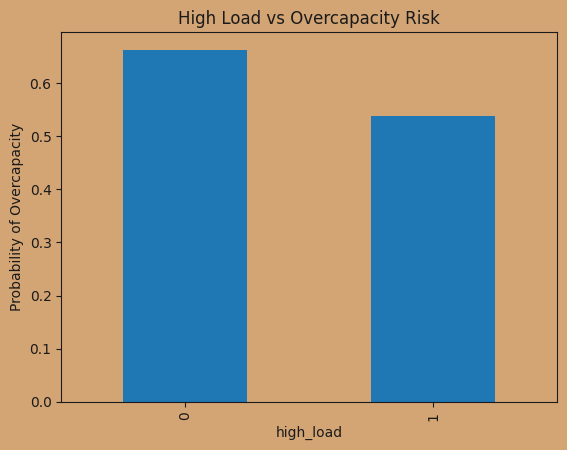

In [37]:
# ----------------------------
# Treatment vs. Outcome
# ----------------------------

plt.figure()
df.groupby("high_load")["over_capacity"].mean().plot(kind="bar")
plt.title("High Load vs Overcapacity Risk")
plt.ylabel("Probability of Overcapacity")
plt.show()

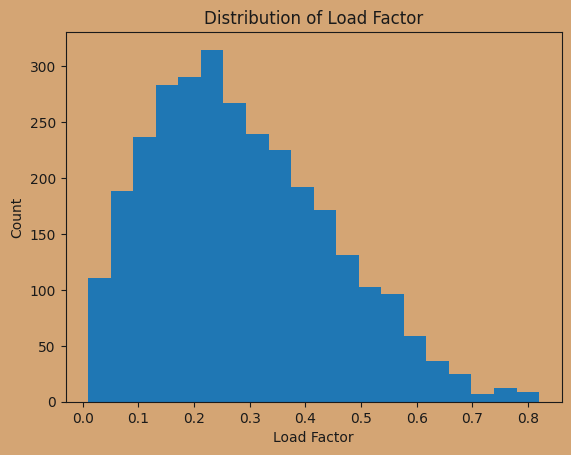

In [39]:
# ----------------------------
# Load Factor Distribution
# ----------------------------

plt.figure()
plt.hist(df["load_factor"], bins=20)
plt.title("Distribution of Load Factor")
plt.xlabel("Load Factor")
plt.ylabel("Count")
plt.show()

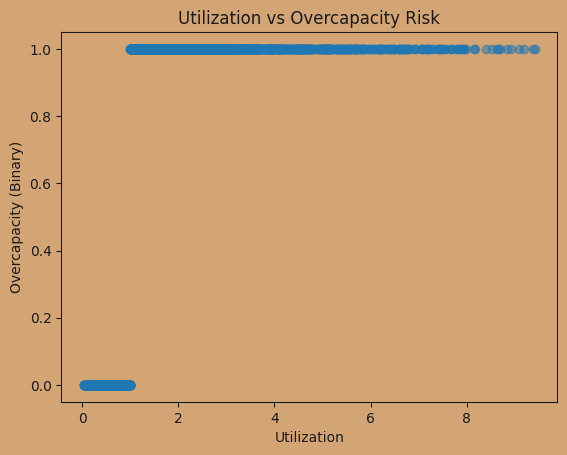

In [41]:
# ----------------------------
# Utilization vs. Overcapacity
# ----------------------------

plt.figure()
plt.scatter(df["utilization"], df["over_capacity"], alpha=0.5)
plt.xlabel("Utilization")
plt.ylabel("Overcapacity (Binary)")
plt.title("Utilization vs Overcapacity Risk")
plt.show()

In [43]:
# ----------------------------
# EconML Setup
# ----------------------------

# Variable Definition

# Outcome
Y = df["over_capacity"].values

# Treatment
T = df["high_load"].values.reshape(-1, 1)

# Confounders (keep it minimal + interpretable)
X = df[["utilization", "agents", "capacity"]].values

In [47]:
# ---------------------------------
# Residualize the Outcome (Y ⟂ X)
# ---------------------------------

# Model outcome using confounders
model_y = LinearRegression()
model_y.fit(X, Y)

# Residualized outcome
Y_resid = Y - model_y.predict(X)

In [49]:
# -----------------------------------
# Residualize the Treatment (T ⟂ X)
# -----------------------------------

model_t = LinearRegression()
model_t.fit(X, T)

# Residualized treatment
T_resid = T.flatten() - model_t.predict(X).flatten()

In [53]:
# ----------------------------------
# Casual Effect by Final Regression
# ----------------------------------

final_model = LinearRegression()
final_model.fit(T_resid.reshape(-1, 1), Y_resid)

ate_manual = final_model.coef_[0]
print("Manual DML-style ATE:", ate_manual)

Manual DML-style ATE: 0.0016291512232311236


In [55]:
# ----------------------------------
# Linear Model
# ----------------------------------

individual_effects = ate_manual * T_resid

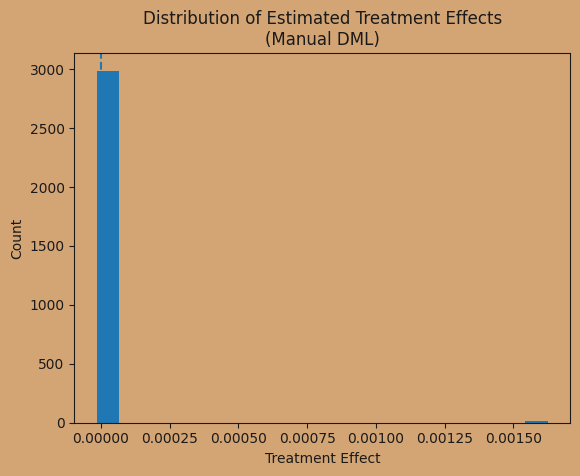

In [57]:
# ----------------------------------
# Linear Model Visualization
# ----------------------------------

plt.figure()
plt.hist(individual_effects, bins=20)
plt.axvline(np.mean(individual_effects), linestyle="--")
plt.title("Distribution of Estimated Treatment Effects\n(Manual DML)")
plt.xlabel("Treatment Effect")
plt.ylabel("Count")
plt.show()

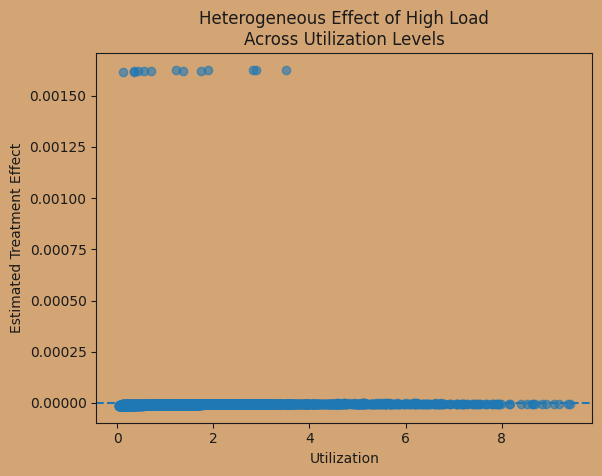

In [59]:
# ----------------------------------
# Treatment Effect vs. Utilization
# ----------------------------------

plt.figure()
plt.scatter(df["utilization"], individual_effects, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Utilization")
plt.ylabel("Estimated Treatment Effect")
plt.title("Heterogeneous Effect of High Load\nAcross Utilization Levels")
plt.show()

In [61]:
print("Naive ATE:", df.loc[df.high_load == 1, "over_capacity"].mean()
      - df.loc[df.high_load == 0, "over_capacity"].mean())

print("Manual DML ATE:", ate_manual)

Naive ATE: -0.12474569287424997
Manual DML ATE: 0.0016291512232311236
